In [2]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
from pyspark.sql.functions import col, count, sum as sum_, avg,when, isnan,trim,mean, stddev, min, max, count, expr
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType, IntegerType,StringType
from pyspark.ml.feature import Imputer,VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/15 03:17:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:

#02-DU
# Schemas can only be inferred for CSV files. 
df = spark.read.csv('Datasets/Sleep_health_and_lifestyle_dataset.csv', inferSchema=True, header=True)

file_path = "Datasets/modified_sleep_health_and_lifestyle.csv"
df_merge = spark.read.csv(file_path, header=True, inferSchema=True)


df.printSchema()

root
 |-- Person ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: double (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Daily Steps: integer (nullable = true)
 |-- Sleep Disorder: string (nullable = true)
 |-- Has Sleep Disorder: integer (nullable = true)



In [8]:
df.show()

+---------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+------------------+
|Person ID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|Has Sleep Disorder|
+---------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+------------------+
|        1|Female|  37|   Teacher|           7.4|               8|                     60|           4|      Normal|        114/76|        67|       7000|          None|                 0|
|        2|Female|  57|     Nurse|           8.3|               9|                     75|           3|  Overweight|        140/96|        66|       7000|   Sleep Apnea|                 1|
|        3|Female|  49|     Nurse|           6.1|      

In [7]:
df.describe().show()

+-------+-----------------+------+-----------------+----------+------------------+------------------+-----------------------+-----------------+------------+--------------+------------------+------------------+--------------+------------------+
|summary|        Person ID|Gender|              Age|Occupation|    Sleep Duration|  Quality of Sleep|Physical Activity Level|     Stress Level|BMI Category|Blood Pressure|        Heart Rate|       Daily Steps|Sleep Disorder|Has Sleep Disorder|
+-------+-----------------+------+-----------------+----------+------------------+------------------+-----------------------+-----------------+------------+--------------+------------------+------------------+--------------+------------------+
|  count|             3000|  3000|             2952|      3000|              2917|              2937|                   2952|             2984|        2957|          2978|              2950|              2946|          3000|              3000|
|   mean|           1500

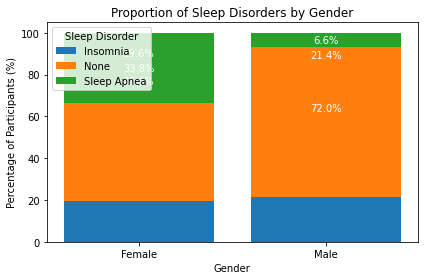

In [14]:
# Count the number of sleep disorders by gender
disorder_by_gender = df.groupBy("Gender", "Sleep Disorder").agg(count("*").alias("count"))

# Calculate the total number of each gender to compute the percentage
total_by_gender = disorder_by_gender.groupBy("Gender").agg(sum_("count").alias("total"))

# Calculate percentage and convert to a new DataFrame
disorder_by_gender_percentage = disorder_by_gender.join(total_by_gender, "Gender")\
    .withColumn("percentage", col("count") / col("total") * 100)\
    .select("Gender", "Sleep Disorder", "percentage")

# Collect data locally for Matplotlib plotting
data = disorder_by_gender_percentage.collect()

# Prepare plotting data
genders = sorted(list(set([row['Gender'] for row in data])))
disorders = sorted(list(set([row['Sleep Disorder'] for row in data])))
data_dict = {gender: {disorder: 0 for disorder in disorders} for gender in genders}

for row in data:
    data_dict[row['Gender']][row['Sleep Disorder']] = row['percentage']

# Convert data to a format suitable for plotting
plot_data = {key: [data_dict[key][disorder] for disorder in disorders] for key in genders}

# Plot stacked bar chart
fig, ax = plt.subplots()

bottom = [0] * len(genders)
for disorder in disorders:
    values = [plot_data[gender][disorders.index(disorder)] for gender in genders]
    ax.bar(genders, values, bottom=bottom, label=disorder)
    bottom = [i + j for i, j in zip(bottom, values)]

# Add title and axis labels
ax.set_title('Proportion of Sleep Disorders by Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Percentage of Participants (%)')

# Add legend
ax.legend(title='Sleep Disorder')

# Add percentage annotations on the bars
for i, gender in enumerate(genders):
    for j, disorder in enumerate(disorders):
        percentage = data_dict[gender][disorder]
        if percentage > 0:
            ax.text(i, bottom[i] - plot_data[gender][j] / 2, f'{percentage:.1f}%', ha='center', va='center', color='white')

# Show plot
plt.tight_layout()
plt.show()


NameError: name 'np' is not defined

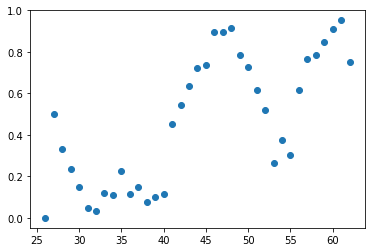

In [20]:
## Filter out rows where 'Age' is None
df = df.filter(col("Age").isNotNull())

# Group data by 'Age' and calculate the mean value of 'Has Sleep Disorder' for each age
age_disorder_relation = df.groupBy("Age").agg(avg("Has Sleep Disorder").alias("average_disorder"))

# Collect data locally for plotting
data = age_disorder_relation.collect()
data.sort(key=lambda x: x['Age'])

# Extract age and average disorder values
ages = [row['Age'] for row in data]
average_disorders = [row['average_disorder'] for row in data]

# Create a scatter plot of the age and proportion of sleep disorders
plt.scatter(ages, average_disorders, label='Data Points')

# Fit a trend line to the data
z = np.polyfit(ages, average_disorders, 1)
p = np.poly1d(z)
plt.plot(ages, p(ages), "r--", label='Trend Line')

# Set plot title and labels
plt.title('Relationship between Age and Sleep Disorders')
plt.xlabel('Age')
plt.ylabel('Proportion with Sleep Disorders')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()

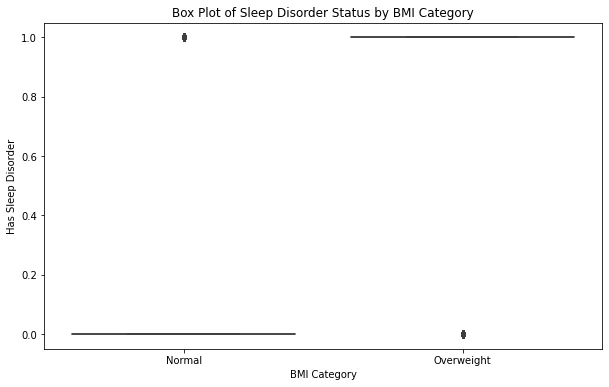

In [32]:
# Filter out rows where 'BMI Category' or 'Has Sleep Disorder' is None
df_filtered = df.filter(col("BMI Category").isNotNull() & col("Has Sleep Disorder").isNotNull())

# Collect data for plotting
data = df_filtered.select("BMI Category", "Has Sleep Disorder").collect()

# Prepare data for plotting
bmi_categories = [row['BMI Category'] for row in data]
has_sleep_disorder = [row['Has Sleep Disorder'] for row in data]

# Create a dictionary for plotting
plot_data = {'BMI Category': bmi_categories, 'Has Sleep Disorder': has_sleep_disorder}

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(x='BMI Category', y='Has Sleep Disorder', data=plot_data)

# Set the title and labels
plt.title('Box Plot of Sleep Disorder Status by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Has Sleep Disorder')

# Show the plot
plt.show()

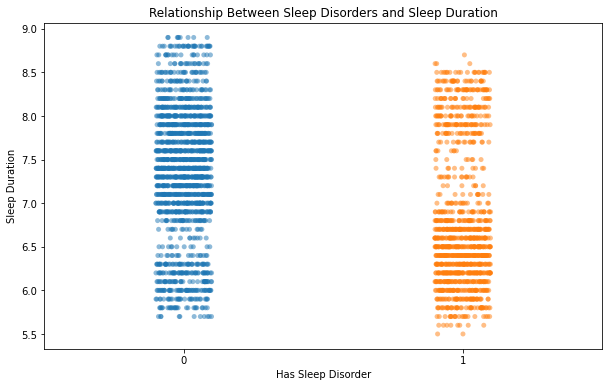

In [39]:
# Select relevant columns and drop rows with missing values
df = df.select("Has Sleep Disorder", "Sleep Duration").dropna()

# Convert to Pandas DataFrame for plotting
df_pd = df.toPandas()
# Plotting
plt.figure(figsize=(10, 6))
sns.stripplot(x="Has Sleep Disorder", y="Sleep Duration", data=df_pd, jitter=True, alpha=0.5)
plt.title("Relationship Between Sleep Disorders and Sleep Duration")
plt.xlabel("Has Sleep Disorder")
plt.ylabel("Sleep Duration")
plt.show()

In [44]:
# Fill missing values in 'Occupation' and 'Has Sleep Disorder' columns
df = df.fillna({"Occupation": "Unknown", "Has Sleep Disorder": 0})

# Calculate the count of each occupation with sleep disorders
occupation_disorder_count = df.groupBy("Occupation").agg(count(when(col("Has Sleep Disorder") == 1, True)).alias("count_disorder"))

# Calculate the total count of each occupation
occupation_total_count = df.groupBy("Occupation").agg(count("Person ID").alias("total_count"))

# Calculate the percentage
occupation_disorder_percentage = occupation_disorder_count.join(occupation_total_count, "Occupation")
occupation_disorder_percentage = occupation_disorder_percentage.withColumn("percentage", (col("count_disorder") / col("total_count")) * 100)

# Convert the result to pandas DataFrame for plotting
occupation_disorder_percentage_pd = occupation_disorder_percentage.toPandas()

# Sort the DataFrame by percentage
occupation_disorder_percentage_pd = occupation_disorder_percentage_pd.sort_values(by="percentage", ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x="percentage", y="Occupation", data=occupation_disorder_percentage_pd, palette="coolwarm")
for index, row in occupation_disorder_percentage_pd.iterrows():
    plt.text(row["percentage"], index, f'{row["percentage"]:.2f}% | Count: {int(row["count_disorder"])}', color='black', ha="left", va="center")
plt.title("Proportion of Sleep Disorders by Occupation")
plt.xlabel("Proportion (%)")
plt.ylabel("Occupation")
plt.show()

AnalysisException: Cannot resolve column name "Occupation" among (Has Sleep Disorder, Sleep Duration)

In [63]:
# 2.4 Verify the Data
# Define function to calculate completeness
def completeness(column):
    return (df.filter((col(column).isNotNull()) & (col(column) != "")).count() / df.count()) * 100

# Define function to calculate missing values
def missing_values(column):
    return df.filter((col(column).isNull()) | (col(column) == "")).count()

# Define function to calculate outliers
def outlier_count(column):
    if isinstance(df.schema[column].dataType, (DoubleType, IntegerType)):
        Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
        Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    return 0

# Define function to calculate extremes
def extreme_count(column):
    if isinstance(df.schema[column].dataType, (DoubleType, IntegerType)):
        Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
        Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        return df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    return 0

# Calculate completeness, missing values, outliers, and extremes for each column
columns = df.columns
completeness_dict = {column: completeness(column) for column in columns}
missing_values_dict = {column: missing_values(column) for column in columns}
outliers_dict = {column: outlier_count(column) for column in columns}
extremes_dict = {column: extreme_count(column) for column in columns}

# Create a summary DataFrame
summary_data = [(column, completeness_dict[column], missing_values_dict[column], outliers_dict[column], extremes_dict[column]) for column in columns]
summary_df = spark.createDataFrame(summary_data, ["Field", "Completeness (%)", "Missing Values Count", "Outliers", "Extremes"])

# Display the data quality summary
summary_df.show(truncate=False)

+------------------+----------------+--------------------+--------+--------+
|Field             |Completeness (%)|Missing Values Count|Outliers|Extremes|
+------------------+----------------+--------------------+--------+--------+
|Has Sleep Disorder|0.0             |0                   |0       |0       |
|Sleep Duration    |0.0             |0                   |0       |0       |
+------------------+----------------+--------------------+--------+--------+



In [10]:
# Select numeric columns for descriptive statistics
numeric_columns = [
    'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
    'Stress Level', 'Heart Rate', 'Daily Steps'
]

# Wrap column names with backticks
numeric_columns_quoted = [f"`{col}`" for col in numeric_columns]

# Calculate descriptive statistics
desc_stats = df.select(
    [count(col(c)).alias(f"{c}_count") for c in numeric_columns] +
    [mean(col(c)).alias(f"{c}_mean") for c in numeric_columns] +
    [stddev(col(c)).alias(f"{c}_stddev") for c in numeric_columns] +
    [min(col(c)).alias(f"{c}_min") for c in numeric_columns] +
    [max(col(c)).alias(f"{c}_max") for c in numeric_columns] +
    [expr(f"percentile_approx({c}, 0.25)").alias(f"{c}_25th") for c in numeric_columns_quoted] +
    [expr(f"percentile_approx({c}, 0.5)").alias(f"{c}_50th") for c in numeric_columns_quoted] +
    [expr(f"percentile_approx({c}, 0.75)").alias(f"{c}_75th") for c in numeric_columns_quoted]
)

# Convert to Pandas DataFrame for easier viewing
desc_stats_pd = desc_stats.toPandas().transpose()
desc_stats_pd.columns = desc_stats_pd.iloc[0]
desc_stats_pd = desc_stats_pd.drop(desc_stats_pd.index[0])

# Split the index to separate field names and statistics
desc_stats_pd.index = desc_stats_pd.index.str.rsplit('_', 1, expand=True)
desc_stats_final = desc_stats_pd.unstack(level=-1)
desc_stats_final.columns = desc_stats_final.columns.droplevel(0)
desc_stats_final.reset_index(inplace=True)
desc_stats_final.columns.name = None

# Display the final DataFrame
desc_stats_final

,index,25th,50th,75th,count,max,mean,min,stddev
0,Age,NaN,NaN,NaN,NaN,62.0,42.151762,26.0,8.706907
1,Daily Steps,NaN,NaN,NaN,2946.0,10000.0,6840.224033,3000.0,1597.496285
2,Heart Rate,NaN,NaN,NaN,2950.0,90.0,70.122034,62.0,4.566158
3,Physical Activity Level,NaN,NaN,NaN,2952.0,90.0,59.178523,30.0,20.490040
4,Quality of Sleep,NaN,NaN,NaN,2937.0,9.0,7.318012,4.0,1.195042
5,Sleep Duration,NaN,NaN,NaN,2917.0,8.9,7.135516,5.5,0.818112
6,Stress Level,NaN,NaN,NaN,2984.0,8.0,5.356233,3.0,1.754867
7,`Age`,36.0,42.0,49.0,NaN,NaN,NaN,NaN,NaN
8,`Daily Steps`,6000.0,7000.0,8000.0,NaN,NaN,NaN,NaN,NaN
9,`Heart Rate`,67.0,70.0,73.0,NaN,NaN,NaN,NaN,NaN


In [11]:
# Select the Blood Pressure column
bp_df = df.select("Blood Pressure")

# Show the Blood Pressure column data
bp_df.show(20, truncate=False)

+--------------+
|Blood Pressure|
+--------------+
|114/76        |
|140/96        |
|139/95        |
|126/82        |
|124/81        |
|134/90        |
|120/81        |
|114/74        |
|114/76        |
|129/85        |
|126/79        |
|125/80        |
|141/95        |
|116/74        |
|140/94        |
|129/84        |
|116/75        |
|116/77        |
|130/84        |
|135/89        |
+--------------+
only showing top 20 rows



In [16]:
# Remove the Blood Pressure and Daily Steps columns
df_cleaned = df.drop("Blood Pressure", "Daily Steps")


# Show the schema of the remaining columns
df_cleaned.printSchema()

root
 |-- Person ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: double (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Sleep Disorder: string (nullable = true)
 |-- Has Sleep Disorder: integer (nullable = true)



In [40]:
# Function to calculate missing value rates
def calculate_missing_value_rates(df):
    total_count = df.count()
    missing_data = df.select([(count(when(col(c).isNull(), c)) / total_count).alias(c) for c in df.columns])
    return missing_data

# Display the initial missing value rates
print("Initial missing value rates:")
initial_missing_rates = calculate_missing_value_rates(df)
initial_missing_rates.show(vertical=True)

# Impute numerical columns
num_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]
imputer_num = Imputer(inputCols=num_cols, outputCols=[f"{col}_imputed" for col in num_cols]).setStrategy("mean")
df = imputer_num.fit(df).transform(df)

# Impute categorical columns
cat_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
for col_name in cat_cols:
    mode = df.groupBy(col_name).count().orderBy('count', ascending=False).first()[0]
    df = df.fillna({col_name: mode})

# Remove original columns after imputation
df = df.drop(*num_cols)

# Rename imputed columns to original names
for col_name in num_cols:
    df = df.withColumnRenamed(f"{col_name}_imputed", col_name)

# Display the missing value rates after imputation
print("Missing value rates after imputation:")
post_imputation_missing_rates = calculate_missing_value_rates(df)
post_imputation_missing_rates.show(vertical=True)


Initial missing value rates:
-RECORD 0---------------------------------------
 Person ID               | 0.0                  
 Gender                  | 0.0                  
 Age                     | 0.016                
 Occupation              | 0.0                  
 Sleep Duration          | 0.027666666666666666 
 Quality of Sleep        | 0.021                
 Physical Activity Level | 0.016                
 Stress Level            | 0.005333333333333333 
 BMI Category            | 0.014333333333333333 
 Blood Pressure          | 0.007333333333333333 
 Heart Rate              | 0.016666666666666666 
 Daily Steps             | 0.018                
 Sleep Disorder          | 0.0                  
 Has Sleep Disorder      | 0.0                  

Missing value rates after imputation:
-RECORD 0----------------------
 Gender                  | 0.0 
 Occupation              | 0.0 
 BMI Category            | 0.0 
 Blood Pressure          | 0.0 
 Sleep Disorder          | 0.0 
 Pers

In [41]:
# Function to detect outliers
def detect_outliers(df, column_name):
    Q1 = df.approxQuantile(column_name, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column_name, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df.filter((col(column_name) < lower_bound) | (col(column_name) > upper_bound))
    return outliers

# Function to handle outliers
def handle_outliers(df, column_name):
    Q1 = df.approxQuantile(column_name, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column_name, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df.withColumn(column_name, expr(f"CASE WHEN `{column_name}` < {lower_bound} THEN {lower_bound} WHEN `{column_name}` > {upper_bound} THEN {upper_bound} ELSE `{column_name}` END"))
    return df

# Detect outliers before processing
heart_rate_outliers_before = detect_outliers(df, 'Heart Rate')
print(f"Number of outliers in heart rate data before processing: {heart_rate_outliers_before.count()}")

# Handle outliers
df = handle_outliers(df, 'Heart Rate')

# Detect outliers after processing
heart_rate_outliers_after = detect_outliers(df, 'Heart Rate')
print(f"Number of outliers in heart rate data after processing: {heart_rate_outliers_after.count()}")

Number of outliers in heart rate data before processing: 111
Number of outliers in heart rate data after processing: 0


In [42]:
# Create the "is_overweight" column
df = df.withColumn('is_overweight', when(col('BMI Category') == 'Overweight', 1).otherwise(0))

In [43]:
# Calculate Quality of Sleep score: multiplied by 5 to scale from 1-10 to 0-50
df = df.withColumn("quality_score", col("Quality of Sleep") * 5)

# Calculate Sleep Duration score
df = df.withColumn(
    "duration_score",
    when(col("Sleep Duration") < 5, 0)
    .when((col("Sleep Duration") >= 5) & (col("Sleep Duration") < 7), 25)
    .otherwise(50)
)

# Calculate the total sleep score
df = df.withColumn("sleep_score", col("quality_score") + col("duration_score"))

# Show the dataframe with the new columns
df.select("Quality of Sleep", "Sleep Duration", "quality_score", "duration_score", "sleep_score").show(20, truncate=False)


+----------------+-----------------+-------------+--------------+-----------+
|Quality of Sleep|Sleep Duration   |quality_score|duration_score|sleep_score|
+----------------+-----------------+-------------+--------------+-----------+
|8               |7.4              |40           |50            |90         |
|9               |8.3              |45           |50            |95         |
|6               |6.1              |30           |25            |55         |
|6               |6.1              |30           |25            |55         |
|6               |6.3              |30           |25            |55         |
|7               |7.0              |35           |50            |85         |
|7               |7.135515941035303|35           |50            |85         |
|8               |7.135515941035303|40           |50            |90         |
|8               |7.135515941035303|40           |50            |90         |
|8               |7.135515941035303|40           |50            

In [3]:
# Load the datasets
blood_pressure_file_path = "Datasets/BloodPressure.csv"  # Replace with your actual file path
sleep_data_file_path = "Datasets/Sleep_health_and_lifestyle_dataset.csv"  # Replace with your actual file path

blood_pressure_data = spark.read.csv(blood_pressure_file_path, header=True, inferSchema=True)
sleep_data = spark.read.csv(sleep_data_file_path, header=True, inferSchema=True)

# Rename duplicate columns in blood_pressure_data
for col_name in blood_pressure_data.columns:
    if col_name in sleep_data.columns and col_name != 'Person ID':
        blood_pressure_data = blood_pressure_data.withColumnRenamed(col_name, f"{col_name}_bp")

# Merge the datasets using 'Person ID' as the key
merged_data = blood_pressure_data.join(sleep_data, on='Person ID', how='inner')

# Remove duplicate records if any
merged_data = merged_data.dropDuplicates(subset=['Person ID'])



# Verify the merge
merged_data.printSchema()

root
 |-- Person ID: integer (nullable = true)
 |-- Blood Pressure_bp: string (nullable = true)
 |-- Systolic: integer (nullable = true)
 |-- Diastolic: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: double (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Daily Steps: integer (nullable = true)
 |-- Sleep Disorder: string (nullable = true)
 |-- Has Sleep Disorder: integer (nullable = true)



In [8]:
# 4-DT
# 4.1
# Select numerical columns for correlation calculation
numeric_cols = [field.name for field in merged_data.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType))]

# Calculate the correlation matrix
correlations = {}
for col1 in numeric_cols:
    for col2 in numeric_cols:
        if col1 != col2:
            corr_value = merged_data.stat.corr(col1, col2)
            correlations[(col1, col2)] = corr_value

# Convert the correlations dictionary to a DataFrame
correlations_df = spark.createDataFrame([(k[0], k[1], v) for k, v in correlations.items()], ["col1", "col2", "correlation"])

# Extract the correlations with the target variable 'Has Sleep Disorder'
target_var = 'Has Sleep Disorder'
correlations_with_target = correlations_df.filter((correlations_df.col1 == target_var) | (correlations_df.col2 == target_var))

# Sort the correlations with the target variable in descending order
correlations_with_target = correlations_with_target.orderBy("correlation", ascending=False)

# Display the correlations with the target variable
correlations_with_target.show(truncate=False)

+-----------------------+-----------------------+---------------------+
|col1                   |col2                   |correlation          |
+-----------------------+-----------------------+---------------------+
|Has Sleep Disorder     |Diastolic              |0.4413632734605211   |
|Diastolic              |Has Sleep Disorder     |0.4413632734605211   |
|Has Sleep Disorder     |Systolic               |0.3874203179772385   |
|Systolic               |Has Sleep Disorder     |0.38742031797723847  |
|Has Sleep Disorder     |Age                    |0.3690176335458678   |
|Age                    |Has Sleep Disorder     |0.36901763354586775  |
|Stress Level           |Has Sleep Disorder     |0.19389881385146074  |
|Has Sleep Disorder     |Stress Level           |0.19389881385146066  |
|Has Sleep Disorder     |Heart Rate             |0.11704122913724023  |
|Heart Rate             |Has Sleep Disorder     |0.11704122913724019  |
|Physical Activity Level|Has Sleep Disorder     |0.0339206710573

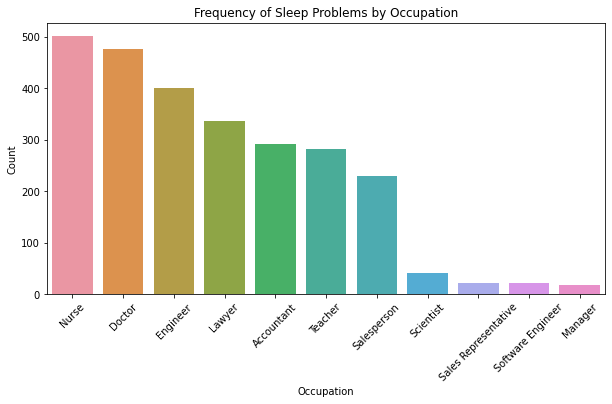

In [5]:
# Load the dataset
file_path = "Datasets/modified_sleep_health_and_lifestyle.csv"
df_merge = spark.read.csv(file_path, header=True, inferSchema=True)

# Group by 'Occupation' and count the occurrences
occupation_counts = df_merge.groupBy("Occupation").agg(count("Occupation").alias("Count")).orderBy(col("Count").desc())

# Convert to Pandas for visualization
occupation_counts_pd = occupation_counts.toPandas()

# Plot the data
plt.figure(figsize=(10, 5))
sns.barplot(x=occupation_counts_pd['Occupation'], y=occupation_counts_pd['Count'])
plt.title('Frequency of Sleep Problems by Occupation')
plt.xticks(rotation=45)
plt.show()

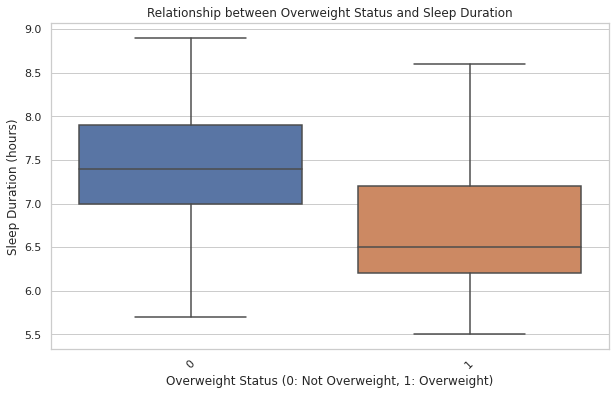

In [7]:
# Select the required columns and convert to Pandas DataFrame
overweight_sleep_df = df_merge.select("is_overweight", "Sleep Duration").toPandas()


# Set plot style
sns.set(style="whitegrid")

# Generate the plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="is_overweight", y="Sleep Duration", data=overweight_sleep_df)
plt.title('Relationship between Overweight Status and Sleep Duration')
plt.xlabel('Overweight Status (0: Not Overweight, 1: Overweight)')
plt.ylabel('Sleep Duration (hours)')
plt.xticks(rotation=45)
plt.show()

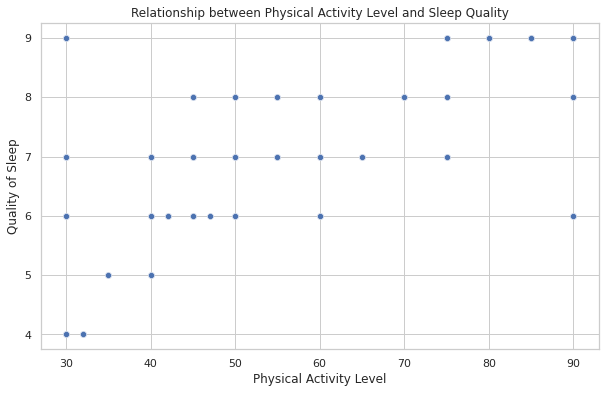

In [10]:
# Select the required columns and convert to Pandas DataFrame
activity_sleep_df = df_merge.select("Physical Activity Level", "Quality of Sleep").toPandas()


# Set plot style
sns.set(style="whitegrid")

# Generate the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Physical Activity Level", y="Quality of Sleep", data=activity_sleep_df)
plt.title('Relationship between Physical Activity Level and Sleep Quality')
plt.xlabel('Physical Activity Level')
plt.ylabel('Quality of Sleep')
plt.show()

In [5]:
# Show dataset schema
df_merge.printSchema()

# Drop columns with unsupported data types
df_merge = df_merge.drop("Gender", "Occupation")

# Prepare the data
feature_columns = df_merge.columns
feature_columns.remove('Has Sleep Disorder')
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Index the label column
indexer = StringIndexer(inputCol="Has Sleep Disorder", outputCol="label")

# Split the data into training and test sets
(trainingData, testData) = df_merge.randomSplit([0.7, 0.3])

# Create the Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

# Create the pipeline
pipeline = Pipeline(stages=[assembler, indexer, rf])

# Train the model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")

# Analyze feature importance
rf_model = model.stages[-1]
importances = rf_model.featureImportances
features = assembler.getInputCols()
importance_list = [(features[i], importances[i]) for i in range(len(importances))]
importance_df = spark.createDataFrame(importance_list, ["Feature", "Importance"]).orderBy(col("Importance").desc())

print("Feature Importances:")
importance_df.show(truncate=False)

# Show the first few predictions
predictions.select("prediction", "label", "features").show(5)


root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: double (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Daily Steps: integer (nullable = true)
 |-- Has Sleep Disorder: integer (nullable = true)
 |-- is_overweight: integer (nullable = true)
 |-- Sleep_Score: integer (nullable = true)



Test Accuracy = 0.9363295880149812


TypeError: Unable to infer the type of the field Importance.